In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
from src.emfiles import get_data_from_df
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
import mrcfile

### Read the data

In [32]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"

data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
star_file = "AUG11_99Kparticles_updatedGCTF.star"


df = star.parse_star(data_dir + star_file, keep_index = False)

imgs, pixel_size, angles, shifts, ctf_params = get_data_from_df(df, data_dir)

nx = imgs.shape[-1]
N = imgs.shape[0]

KeyError: 'rlnImagePixelSize'

In [31]:
print(imgs.shape)
print(pixel_size.shape)
print(angles.shape)
print(shifts.shape)
print(ctf_params.shape)

(334, 458, 458)
(334,)
(334, 3)
(334, 2)
(334, 9)


In [27]:
imgs_f = np.fft.fft2(imgs)
imgs_f = imgs_f.reshape(imgs_f.shape[0], -1)
imgs_f.shape

(63, 94864)

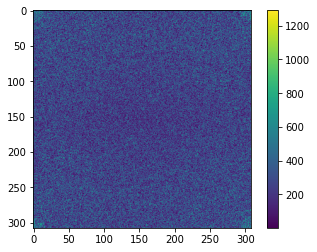

In [6]:
plt.imshow(np.abs(imgs_f[100].reshape(nx,nx))); plt.colorbar()

### Create the grids

In [7]:
# Assume the pixel size is the same for all images
px = pixel_size[0]

x_freq = np.fft.fftfreq(nx, px)
y_freq = np.fft.fftfreq(nx, px)
z_freq = np.fft.fftfreq(nx, px)

# Important thast the grids are not jax (aka Tracer)  objects
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

In [8]:
@jax.jit
def slice_func(v, angles, shifts, ctf_params):
    projection, _ = project(v, x_grid, y_grid, z_grid, angles, shifts, "tri", ctf_params)

    return projection

@jax.jit
def slice_func_array(v, angles, shifts, ctf_params):    
    return jax.vmap(slice_func, in_axes = (None, 0, 0, 0))(v, angles)

In [16]:
@jax.jit
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, shifts, ctf_params, img, alpha = 0.1):
    #return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    
    # With l2 regularization
    return 1/(2* nx*nx) * (alpha * l2sq(v) + l2sq(slice_func(v, angles, shifts, ctf_params) - img))


@jax.jit
def loss_func_batched(v, angles, shifts, ctf_params, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0, 0, 0))(v, angles, shifts, ctf_params, imgs)

@jax.jit
def loss_func_sum(v, angles, shifts, ctf_params, imgs):
    return jnp.mean(loss_func_batched(v, angles, shifts, ctf_params, imgs))

In [17]:
@jax.jit
def grad_loss_volume(v, angles, shifts, ctf_params, img):
    return jax.grad(loss_func)(v, angles, shifts, ctf_params, img)

@jax.jit
def grad_loss_volume_batched(v, angles, shifts, ctf_params, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0, 0, 0))(v, angles, shifts, ctf_params, imgs), axis=0)

@jax.jit
def grad_loss_volume_sum(v, angles, shifts, ctf_params, imgs):
    return jax.grad(loss_func_sum)(v, angles, shifts, ctf_params, imgs)



Test the functions above with a random volume

In [18]:
vf = jnp.array(np.random.randn(nx,nx,nx))

In [19]:
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(94864,)

In [21]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

0.0016307830810546875
(308, 308, 308)


In [23]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

0.009484291076660156
(308, 308, 308)


### CG

In [24]:
from src.algorithm import conjugate_gradient

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 100
zero = jnp.zeros(v0.shape).astype(jnp.complex128)
Ab = - jnp.conj(grad_loss_volume_sum(zero, angles, shifts, ctf_params, imgs_f))
AA = lambda vv : jnp.conj(grad_loss_volume_sum(vv, angles, shifts, ctf_params, imgs_f)) + Ab

vcg, max_iter = conjugate_gradient(AA, Ab, v0, N_iter, verbose = True)



RuntimeError: Resource exhausted: Out of memory while trying to allocate 22784137216 bytes.

In [ ]:
print("Final loss function = ", loss_func_sum(vcg, angles, shifts, ctf_params, imgs_f))

In [ ]:
i = 80
s0 = slice_func(vcg, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

In [ ]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))))
plt.colorbar()
plt.title('Reconstruction MIP')